In [4]:
%matplotlib inline

# Example 7.6.1: Mine management
import numpy as np
import matplotlib.pyplot as plt

class MineManagement:
    
    def __init__(self, price, sbar, delta):
        self.price, self.sbar, self.delta = price, sbar, delta
    
    def get_value(self, v_next):
        v_mat = np.array([[self.get_value_sub(s, x, v_next)
            for x in range(self.sbar)] for s in range(self.sbar)])
        return np.max(v_mat, axis=1)
        
    def get_value_sub(self, s, x, v_next):
        return self.reward(s, x) + self.delta * v_next[self.transition(s, x)]

    def reward(self, s, x):
        if s < x:
            return -np.inf
        return self.price * x - self.cost(s, x)

    def cost(self, s, x):
        return x ** 2 / (1 + s)
    
    def transition(self, s, x):
        return s - x
    
    def get_policy(self, s, v):
        return np.argmax([self.get_value_sub(s, x, v) for x in range(self.sbar)])
    
    def value_function_iteration(self):
        v = np.zeros(self.sbar)
        while np.linalg.norm(v - self.get_value(v)) > 1.0e-8:
            v = self.get_value(v)
        policy = np.array([self.get_policy(s, v) for s in range(self.sbar)])
        return v, policy


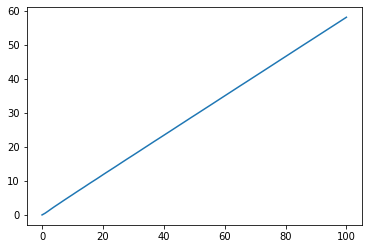

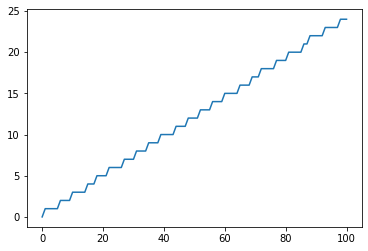

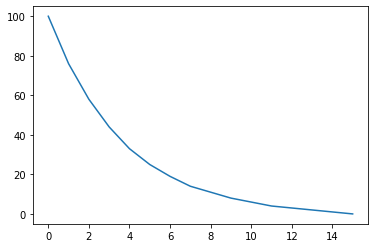

In [5]:
price, sbar, delta = 1, 101, 0.9
mine = MineManagement(price, sbar, delta)
value, policy = mine.value_function_iteration()
state = np.array([i for i in range(sbar)])

plt.plot(state, value)
plt.show()

plt.plot(state, policy)
plt.show()

path_state = [sbar - 1]
t = [0]
while path_state[-1] > 0:
    s = path_state[-1]
    path_state.append(mine.transition(s, policy[s]))
    t.append(t[-1] + 1)

plt.plot(t, path_state)
plt.show()

In [12]:
# Example 7.6.1: Asset replacement
class AssetReplacement:

    def __init__(self, maxage, repcost, delta):
        self.maxage, self.repcost, self.delta = maxage, repcost, delta
    
    def reward(self, a):
        return 50 - 2.5 * a - 2.5 * a ** 2

    def get_value_sub(self, a, x, value_next):
        if x == 1:
            return self.reward(0) - self.repcost + self.delta * value_next[1]
        if a == self.maxage:
            return -np.inf
        return self.reward(a) + self.delta * value_next[a + 1]
    
    def get_value(self, value_next):
        v_mat = np.array([[self.get_value_sub(a, x, value_next)
            for x in [0, 1]] for a in range(self.maxage + 1)])
        return np.max(v_mat, axis=1)
    
    def get_policy(self, a, v):
        return np.argmax([self.get_value_sub(a, x, v) for x in range(self.maxage + 1)])
    
    def value_function_iteration(self):
        value = np.zeros(self.maxage + 1)
        while np.linalg.norm(value - self.get_value(value)) > 1.0e-8:
            value = self.get_value(value)
        policy = np.array([self.get_policy(a, value) for a in range(self.maxage + 1)])
        return value, policy

maxage, repcost, delta = 5, 75, 0.9
asset_replacement = AssetReplacement(maxage, repcost, delta)
asset_replacement.value_function_iteration()

(array([244.90404184, 216.56004649, 190.62227388, 172.91363765,
        169.90404184, 169.90404184]), array([0, 0, 0, 0, 1, 1], dtype=int64))

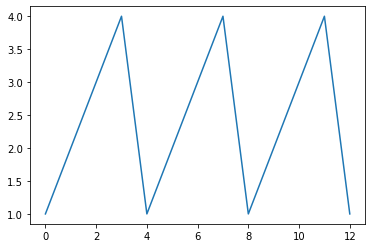

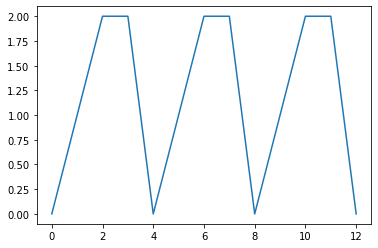

In [59]:
# Example 7.6.3: Asset replacement with maintenance
class AssetReplacement2:

    def __init__(self, maxage, repcost, mancost, delta):
        self.maxage, self.repcost, self.mancost, self.delta \
            = maxage, repcost, mancost, delta
        self.a_space = np.array([a for a in range(1, self.maxage + 1)])
        self.s_space = np.array([s for s in range(self.maxage)])
        self.state_space = np.array([[a, s] for a in self.a_space for s in self.s_space])
        self.na, self.ns = len(self.a_space), len(self.s_space)

    def transition(self, state, x):
        a, s = state
        if x == 0:
            return np.array([a + 1, s])
        if x == 1:
            return np.array([a + 1, s + 1])
        if x == 2:
            return np.array([1, 0])

    def reward_sub(self, a, s):
        return (1 - (a - s) / 5) * (50 - 2.5 * a - 2.5 * a**2)
    
    def reward(self, state, x):
        a, s = state
        if x == 0:
            return self.reward_sub(a, s)
        if x == 1:
            return self.reward_sub(a, s + 1) - self.mancost
        if x == 2:
            return self.reward_sub(0, 0) - self.repcost
    
    def get_state_idx(self, state):
        return self.ns * (state[0] - 1) + state[1]

    def get_value_sub(self, state, x, v):
        state_next = self.transition(state, x)
        state_idx = self.get_state_idx(state_next)
        if state_next[0] not in self.a_space or state_next[1] not in self.s_space \
                or state_next[0] < state_next[1]:
            return -np.inf
        return self.reward(state, x) + self.delta * v[state_idx]
    
    def get_value(self, v):
        v_mat = np.array([[self.get_value_sub(state, x, v) for x in range(3)]
            for state in self.state_space])
        return np.max(v_mat, axis=1)

    def get_policy(self, state, v):
        return np.argmax([self.get_value_sub(state, x, v) for x in range(3)])
    
    def value_function_iteration(self):
        value = np.zeros(self.na * self.ns)
        while np.linalg.norm(value - self.get_value(value)) > 1.0e-8:
            value = self.get_value(value)
        policy = np.array([self.get_policy(state, value) for state in self.state_space])
        return value, policy

maxage, repcost, mancost, delta = 5, 75, 10, 0.9
asset_replacement2 = AssetReplacement2(maxage, repcost, mancost, delta)
value, policy = asset_replacement2.value_function_iteration()

ts = np.array([i for i in range(13)])
state, path_state = np.array([1, 0]), [np.array([1, 0])]
for t in ts[1:]:
    action = asset_replacement2.get_policy(state, value)
    state = asset_replacement2.transition(state, action)
    path_state.append(state)

path_a, path_s = list(zip(*path_state))
plt.plot(ts, path_a)
plt.show()

plt.plot(ts, path_s)
plt.show()